# Fine-tune GPT-2 with British literature.     
In this colab, I fine tune GPT-2 to write British-literature-like sentences.    
This follows the spirit of the tutorial to fine-tune a Germal-recipe GPT-2.      

## **What are we going to do:**

- load the dataset from kaggle
- prepare the dataset and build a ``TextDataset``
- load the pre-trained GPT-2 model and tokenizer
- initialize ``Trainer`` with ``TrainingArguments``
- train and save the model
- test the model

In [ ]:
!pip install transformers==4.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 23.1 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=8a349b7c137e7459885c9f45cc3590f93b983266328d1add64a495c9ef327875
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses


In [ ]:
!nvidia-smi

Sun Apr 16 17:09:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load the dataset from Kaggle

We will download the [British_literature_NLP_Labelled_Phrase](https://www.kaggle.com/datasets/ahmadalijamali/british-literature-nlp-labeld-phrase?resource=download) from Kaggle.   
Please download it to your local disk first from Kaggle as shown in the image.   


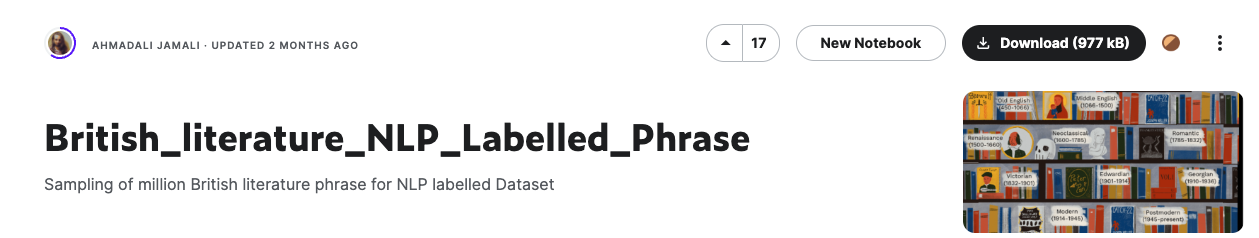

In [ ]:
#upload files to your colab environment
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


After we uploaded the file with use `unzip` to extract the British sentences.

In [ ]:
!unzip 'archive.zip'

Archive:  archive.zip
  inflating: British-literature.csv  


# Prepare the dataset and build a ``TextDataset``

The next step is to extract the instructions from all recipes and build a `TextDataset`. The `TextDataset` is a custom implementation of the [Pytroch `Dataset` class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) implemented by the transformers library. If you want to know more about Dataset in Pytroch you can check out this [youtube video](https://www.youtube.com/watch?v=PXOzkkB5eH0&ab_channel=PythonEngineer).

First, we are going to split the `recipes.json` into a `train` and `test` section and extract `Instructions` from the recipes and write them into a `train_dataset.txt` and `test_dataset.txt`

In [ ]:
import re
import json
from sklearn.model_selection import train_test_split
import pandas as pd

max_sequence_length = 1024

sentences = pd.read_csv("British-literature.csv", header=None)

def clean_sentence(sentence):
  sentence = sentence.replace("]", "").replace("[", "")
  sentence = sentence.replace("-8", "'")
  sentence = sentence.replace("-99", "'")
  sentence = sentence.replace("-9", "'")
  sentence = sentence.replace("-\\-o", "Do")
  sentence = sentence.replace("-\\-", '"')
  sentence = sentence.replace("\\'", "'")
  sentence = sentence.replace("-'", "'")
  sentence = sentence.replace("'4", "-")
  sentence = sentence.replace("-'8", '"')
  sentence = sentence.strip()
  sentence = re.sub(r"\s", " ", sentence)
  return sentence

def get_sentence(row):
  """
  Finds start and end of sentence and returns the sentence
  Cleans sentence
  """
  s = row.values[0]
  tokens = s.split(",")
  if len(tokens) > max_sequence_length:
    tokens = tokens[:max_sequence_length]
  start, end = 0, len(tokens) - 1
  state = 0
  for i, token in enumerate(tokens):
    if state == 0 and "[" in token and "]" in token:
      start = i 
      end = min(i + 1, len(tokens))
    if state == 0 and "[" in token:
      start = i
      state = 1
    elif state == 1 and "]" in token:
      end = min(i + 1, len(tokens))
      break 

  sentence = ",".join(tokens[start:end])
  sentence = clean_sentence(sentence)
  return sentence

def build_text_files(df, dest_path):
    with open(dest_path, 'w') as f:
      data = ''
      for i, row in sentences.iterrows():
        try:
          sentence = get_sentence(row)
        except:
          continue
        else:
          if not sentence:
            continue
          data += sentence + "\n"
      # print("Data ", data)
      f.write(data)

train, test = train_test_split(sentences, test_size=0.15) 

build_text_files(train,'train_dataset.txt')
build_text_files(test,'test_dataset.txt')

print("Train dataset length: "+str(len(train)))
print("Test dataset length: "+ str(len(test)))


Train dataset length: 20820
Test dataset length: 3675


In [ ]:
"""
with open("train_dataset.txt", "r") as f:
  lines = f.readlines()
  for line in lines:
    print(line, end="\n")
"""

'\nwith open("train_dataset.txt", "r") as f:\n  lines = f.readlines()\n  for line in lines:\n    print(line, end="\n")\n'

the next step is to download the tokenizer, which we use. We use the tokenizer from the `gpt2` model on [huggingface](https://huggingface.co/anonymous-german-nlp/german-gpt2).

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

train_path = 'train_dataset.txt'
test_path = 'test_dataset.txt'

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)
     
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)   
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset, test_dataset, data_collator

train_dataset, test_dataset, data_collator = load_dataset(train_path, test_path, tokenizer)

/usr/local/lib/python3.9/dist-packages/transformers/data/datasets/language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_mlm.py
  warnings.warn(


# Initialize `Trainer` with `TrainingArguments` and GPT-2 model

The [Trainer](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Trainer) class provides an API for feature-complete training. It is used in most of the [example scripts](https://huggingface.co/transformers/examples.html) from Huggingface. Before we can instantiate our `Trainer` we need to download our GPT-2 model and create a [TrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) to access all the points of customization during training. In the `TrainingArguments`, we can define the Hyperparameters we are going to use in the training process like our `learning_rate`, `num_train_epochs`, or  `per_device_train_batch_size`. A complete list can you find [here](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments).

In [ ]:
from transformers import Trainer, TrainingArguments,AutoModelWithLMHead

model = AutoModelWithLMHead.from_pretrained("gpt2")


training_args = TrainingArguments(
    output_dir="./gpt2-british",
    overwrite_output_dir=True,
    num_train_epochs=3, 
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    eval_steps = 50, # Number of update steps between two evaluations.
    save_steps=100, # after # steps model is saved 
    warmup_steps=100, # number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

/usr/local/lib/python3.9/dist-packages/transformers/models/auto/modeling_auto.py:921: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


# Train and save the model

To train the model we can simply run `Trainer.train()`.

In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=435, training_loss=3.46495431483477, metrics={'train_runtime': 493.1398, 'train_samples_per_second': 0.882, 'total_flos': 1327464140636160, 'epoch': 3.0})

After training is done you can save the model by calling `save_model()`. This will save the trained model to our `output_dir` from our `TrainingArguments`.

In [ ]:
trainer.save_model()

# Test the model

To test the model we are going to use another [highlight of the transformers library](https://huggingface.co/transformers/main_classes/pipelines.html?highlight=pipelines) called `pipeline`. [Pipelines](https://huggingface.co/transformers/main_classes/pipelines.html?highlight=pipelines) are objects that offer a simple API dedicated to several tasks, among others also `text-generation`

In [ ]:
from transformers import pipeline

text_generator = pipeline('text-generation', model='./gpt2-british', tokenizer='gpt2', config={'max_length':max_sequence_length})

print(text_generator('The cat')[0]['generated_text'])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The cat in the corner shook, and he was about to call out."""   "' She sat down at the counter, and I laid my hand on her shoulder, and she kissed my cheek.'"   ' No word.'   """


In [ ]:
print(text_generator("A tale")[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A tale of intrigue" I told, with the utmost pleasure."""   """ For instance, a young gentleman had come up to us with some documents in Paris from a very early period."""   """ives-in-law, and


In [ ]:
print(text_generator("Mr. George")[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Mr. George.'"   "' ""I heard it, Miss Adams.'"   "'"" ""Yes, Mr.'"   "' Tulliver."""   "' ""And you have made it clear to me that your father and I have
